In [ ]:
!pip3 install gwcloud-python bilby

In [7]:
import json
from pathlib import Path
import bilby

# Recreating figures from GWTC-2

In this tutorial, we will use jobs stored in GWCloud to be able to recreate Fig. 6 and 7 from __[GWTC-2](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.021053)__.

The first step is to authenticate with the GWCloud service by using your API token.

We also set a directory to be used to save and load files that are downloaded from GWCloud.

In [3]:
from gwcloud_python import GWCloud, TimeRange

gwc = GWCloud(token='Your token goes here')

save_dir = Path('./GWTC2Posteriors')

We now obtain a list of jobs for the GWTC-2 events on GWCloud. The desired jobs have been uploaded by Makai Baker, so we use this to filter the public job list.

We then download the results JSON file for each job that matches the list of GWTC-2 job names.

In [ ]:
jobs = gwc.get_public_job_list(search='GWTC-2', time_range=TimeRange.ANY)

for job in jobs:
    if job.name != 'GW190521_eccentric':
        job.save_result_json_files(save_dir)

We now extract the data from the GWTC-2 JSON files and process it.

In [8]:
m1_TC2 = {}
m2_TC2 = {}

chirp_mass_TC2 = {}
mass_ratio_TC2 = {}
total_mass_TC2 = {}

chi_eff_TC2 = {}
chi_p_TC2 = {}

for file in save_dir.glob('result/*.json'):    
    posterior_file = bilby.core.result.read_in_result(filename=file)
    
    posterior = posterior_file.posterior
    posterior_samples = posterior['mass_1'].values

    event = file.stem.replace('_merge_result', '')
        
    m1_TC2[event] = posterior['mass_1_source'].values
    m2_TC2[event] = posterior['mass_2_source'].values
    
    chirp_mass_TC2[event] = posterior['chirp_mass_source'].values
    mass_ratio_TC2[event] = posterior['mass_ratio'].values
    total_mass_TC2[event] = posterior['total_mass_source'].values
    
    chi_eff_TC2[event] = posterior['chi_eff'].values
    chi_p_TC2[event] = posterior['chi_p'].values

Now that we have all the required data, it is time to recreate the plots.

First we import the required plotting libraries and set some defaults.

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner
plt.style.reload_library()
# plt.style.use('publication')

hist_kwargs = dict(
    bins=50,
    smooth=0.9,
    levels = (1-np.exp(-2), ),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=False
)
    
BBH = '#581845'
NSBH = '#900C3F'
BNS = '#C70039'
RAN = '#FFC300'
GW190412 = '#FF5733'
GW190514 = '#17BEBB'
GW190517 = '#A8DADC'

We now recreate __[Figure 6](https://journals.aps.org/prx/article/10.1103/PhysRevX.11.021053/figures/6/medium)__ from the GWTC-2 paper.

<ipython-input-10-088e285d97c8>:43: RuntimeWarning: divide by zero encountered in true_divide
  m2_curve = neutron_star_mass / (MM - neutron_star_mass)


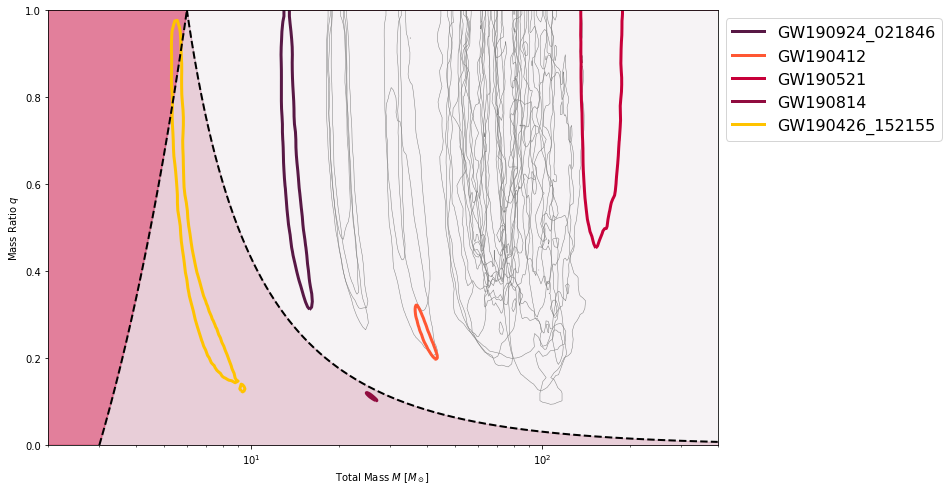

In [10]:
fig, ax = plt.subplots(figsize=(12,8))

for event in m1_TC2:
    corner.hist2d(
        total_mass_TC2[event],
        mass_ratio_TC2[event],
        color='grey',
        alpha=0.2,
        ax=ax,
        contour_kwargs={"linewidths":0.5},
        **hist_kwargs
    )

colour_map = {
    'GW190924_021846': BBH,
    'GW190412': GW190412,
    'GW190521': BNS,
    'GW190814': NSBH,
    'GW190426_152155': RAN,
}

for event, colour in colour_map.items():
    corner.hist2d(
        total_mass_TC2[event],
        mass_ratio_TC2[event],
        label=event,
        color=colour,
        ax=ax,
        contour_kwargs={"linewidths":3, "linestyles":'-'},
        **hist_kwargs
    )

legend_elements = [
    Line2D([0],[0], color=colour, lw='3', ls='-', label=event)
    for event, colour in colour_map.items()
]

ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1,1), fontsize=16)

neutron_star_mass = 3
MM = np.logspace(log10(neutron_star_mass), log10(5000), 10000)
m1_curve = MM / neutron_star_mass - 1
m2_curve = neutron_star_mass / (MM - neutron_star_mass)

ax.plot(MM, m1_curve, 'k--', lw=2)
ax.plot(MM, m2_curve, 'k--', lw=2)

# Hack to colour all the way to x=0
ax.fill_between(np.insert(MM, 0, 0), np.insert(m1_curve, 0, 0), 1.0, color=BNS, alpha=0.5)

ax.fill_between(MM, 0.0, np.min([m1_curve, m2_curve], axis=0), color=NSBH, alpha=0.2)

ax.fill_between(MM, m2_curve, 1.0, color=BBH, alpha=0.05)

ax.set_xlim(2, 400)
ax.set_ylim(0, 1.)
ax.set_xscale('log')

ax.set_xlabel('Total Mass $M$ [$M_\odot$]', fontsize=20)
ax.set_ylabel('Mass Ratio $q$', fontsize=20)

# plt.savefig('GWTC12_masses.pdf')

plt.show()

We now recreate __[Figure 7](https://journals.aps.org/prx/article/10.1103/PhysRevX.11.021053/figures/7/medium)__ from the GWTC-2 paper.

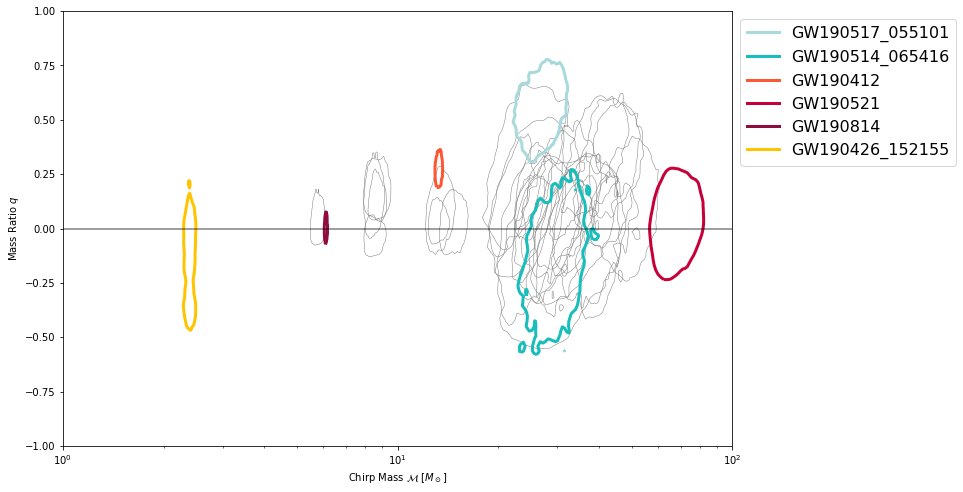

In [11]:
fig, ax = plt.subplots(figsize=(12,8))

for event in m1_TC2:
    corner.hist2d(
        chirp_mass_TC2[event],
        chi_eff_TC2[event],
        color='grey',
        alpha=0.2,
        ax=ax,
        contour_kwargs={"linewidths":0.5},
        **hist_kwargs
    )

colour_map = {
    'GW190517_055101': GW190517,
    'GW190514_065416': GW190514,
    'GW190412': GW190412,
    'GW190521': BNS,
    'GW190814': NSBH,
    'GW190426_152155': RAN,
}

for event, colour in colour_map.items():
    corner.hist2d(
        chirp_mass_TC2[event],
        chi_eff_TC2[event],
        label=event,
        color=colour,
        ax=ax,
        contour_kwargs={"linewidths":3, "linestyles":'-'},
        **hist_kwargs
    )

legend_elements = [
    Line2D([0],[0], color=colour, lw='3', ls='-', label=event)
    for event, colour in colour_map.items()
]

ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1,1), fontsize=16)

ax.axhline(0, color='k', alpha=0.5)

ax.set_xlim(1, 100)
ax.set_ylim(-1, 1.)
ax.set_xscale('log')

ax.set_xlabel('Chirp Mass $\mathcal{M}$ [$M_\odot$]', fontsize=20)
ax.set_ylabel('Mass Ratio $q$', fontsize=20)

plt.show()

# plt.savefig('GWTC12_chieff.pdf')